# Goal
Pricing optimization is, non surprisingly, another area where data science can provide huge value.

The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave diﬀerently as well as any other insights you might ﬁnd.

# Challenge Description
Company XYZ sells a software for $39.Since revenue has been ﬂat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. 

In the experiment, 66 percent of the users have seen the old price (39), while a random sample of 33 percent of users a higher price (59). 

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users. 

Especially he asked you the following questions:
* Should the company sell its software for $39 or $59? 
* The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main ﬁndings looking at the data? 
* [Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically signiﬁcant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.



decision tree 找重要的feature然后用图表visiualize 结果

多久stop test？

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

### Load Dataset

In [3]:
user=pd.read_csv('user_table.csv')
test=pd.read_csv('test_results.csv')

In [4]:
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [5]:
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


Columns:
* user_id : the Id of the user. Can be joined to user_id in user_table 
* timestamp : the date and time when the user hit for the ﬁrst time company XYZ webpage. It is in user local time 

* source : marketing channel that led to the user coming to the site. 
* device : user device. Can be mobile or web operative_system : user operative system. Can be: "windows", "linux", "mac" for web, and "android", "iOS" for mobile. "Other" if it is none of the above 
* test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old/lower  price) 
* price : the price the user sees. It should match test 
* converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).
 

In [96]:
## check uniqueness
print('user_table:\t', user['user_id'].unique().shape)
print('test_table:\t', test['user_id'].unique().shape)

user_table:	 (275616,)
test_table:	 (316800,)


### Data Explore Analysis

In [12]:
merge_data=pd.merge(test,user)

In [13]:
merge_data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [101]:
merge_data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      176241
     59         187
1    39         135
     59       99053

The meaning of test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> oldlower  price)
and price means the price the user sees. They must match each other. 

That is, there is a problem of this dataset: test and price not match. Luckily, they are only small portion og the whole dataset. 
So let's remove these unpaired rows first.

In [103]:
data = merge_data[((merge_data['test']==0) & (merge_data['price']==39)) | ((merge_data['test']==1) & (merge_data['price']==59))]

In [104]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


#### Let's take a glance at whether different price will have an impact on conversion or not. 

In [54]:
group_size=merge_data.groupby('price').converted.count().reset_index()
price_convert=merge_data.groupby('price').converted.mean().reset_index()

In [55]:
print("Different group size: \n", group_size)

print("Diffenent group mean convert rate: \n",price_convert)

Different group size: 
    price  converted
0     39     176376
1     59      99240
Diffenent group mean convert rate: 
    price  converted
0     39   0.019753
1     59   0.015468


#### It seems that low price can have higher conversion rate.

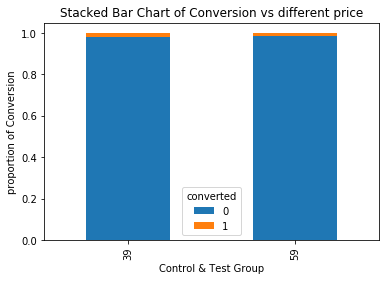

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
table=pd.crosstab(merge_data.price,merge_data.converted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Conversion vs different price')
plt.xlabel('Control & Test Group')
plt.ylabel('proportion of Conversion')
plt.savefig('Conversion proportion for different price')

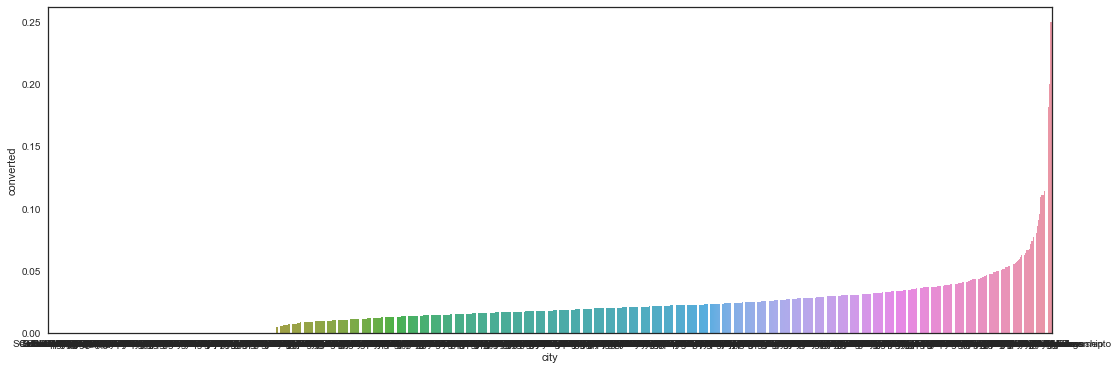

In [67]:
conversion_groupby_city=merge_data[merge_data['test']==0][['converted','city']].groupby('city').mean()
conversion_groupby_city=conversion_groupby_city.reset_index() ##本来行名是country,列名是conversion.现在多了一列index,行是各个index,列是country和conversion
conversion_groupby_city=conversion_groupby_city.sort_values('converted')

# Visualization
fig,ax=plt.subplots(figsize=(18, 6))  ##ax:change the figure size
sns.barplot(x='city', y='converted', data=conversion_groupby_city,ax=ax)
plt.show()

### Build Random Forrest Model to select important features:

#### Data Explore Analysis:

There only one country in this dataset. And price and test have data property. So we drop out thess columns.

In [69]:
merge_data.country.unique()

array(['USA'], dtype=object)

In [74]:
data=merge_data.drop(['country','test'],axis=1)
data.head()

,user_id,timestamp,source,device,operative_system,price,converted,city,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,39,0,Buffalo,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,39,0,Lakeville,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,39,0,Parma,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,59,0,Fayetteville,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,39,0,Fishers,39.95,-86.02


#### convert object to datetime type

Drop outlier: '2015-04-24 12:60:46', this time is impossible in real life

In [91]:
data=data[data.timestamp != '2015-04-24 12:60:46']
data=data[data.timestamp !='2015-04-24 11:60:20']
data=data[data.timestamp !='2015-03-14 12:60:02']
data=data[data.timestamp !='2015-04-04 02:23:60']

In [92]:
data['timestamp']=pd.to_datetime(data['timestamp'],format='%Y-%m-%d %H:%M:%S')

ValueError: time data '2015-05-11 12:60:53' doesn't match format specified

In [ ]:
# Set index
eth.set_index('date', inplace=True)
print(eth.head(5))